In [1]:
from src.gaussian_simulation import *
from src.estimators import *
from src.sgd import *
import numpy as np
from numpy.linalg import norm 
import matplotlib.pylab as plt

On reprend le cadre précédent. On génére un n-échantillon de taille 1024, de loi $p_{\theta}(\mathbf{x}|z)=\mathcal{N}(z, I_{20})$ (selon la procédure décrite par Rainforth et al. (2018)). Pour ce faire, on simule préalablement un échantillon de loi $p_{\theta}(z)$.

In [2]:
np.random.seed(123)

theta=simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
A = np.identity(20)*0.5
b = theta*0.5
echantillon_x=generer_nech_gaussien_x_sachant_z(n=1024, mu_z=theta, sigma_z=np.identity(20),sigma_x=np.identity(20))
print("Vraie valeur de theta: {}".format(np.around(theta, 2)))

Vraie valeur de theta: [-1.09  1.    0.28 -1.51 -0.58  1.65 -2.43 -0.43  1.27 -0.87 -0.68 -0.09
  1.49 -0.64 -0.44 -0.43  2.21  2.19  1.    0.39]


La log-vraisemblance de l'échantillon (avec le facteur $-\frac{1}{n}$) est $l_n(\theta)=\frac{1}{n}\sum_{i=1}^n \lVert X_i - \theta \rVert^2 = \frac{1}{n}\sum_{i=1}^n l_i(\theta) $. 
On cherche $\hat{\theta} \in argmin \; l_n(\theta)$

# Une première estimation de $\theta$

On utilise les estimateurs du gradients de la log-vraisemblance pour estimer $\theta$ à l'aide de la descente de gradient stochastique. Comme nous estimons désormais le gradient de la log-vraisemblance sur plusieurs observations, nous fixons $l=1$ de sorte à ne pas alourdir les temps de calcul. Dans la descente de gradient stochastique usuelle, on estime le gradient de la log vraisemblance par $\nabla_{\theta} l_i(\theta)= -2(X_i-\theta)$. Les hyper-paramètres sont fixés de la façon suivante, après plusieurs tests:
* Nombre d'itérations: 512 (50\% de l'échantillon est parcouru)
* Learning rate: 0,01
* Comme $\theta$ est proche de $0_{\mathbb{R}^{20}}$, on fixe $\theta_0 \sim \mathcal{U}[-3,3[^{20}$.

In [18]:
np.random.seed(123)

u=np.random.uniform(low=-3, high=3, size=20)
theta_SGD=SGD(theta_init=u, learn_rate=0.01, n_iter=512, echantillon=echantillon_x)
theta_iawe=SGD_IAWE(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, k=12)
theta_SUMO=SGD_SUMO(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, l=38)
theta_RR=SGD_RR(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, l=1)
theta_SS=SGD_SS(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, l=1)

print("Theta initial: {}".format(np.around(u, 2)))
print("Vraie valeur de theta: {}".format(np.around(theta, 2)))
print("Estimation de theta par descente de gradient stochastique usuelle: {}".format(np.around(theta_SGD, 2)))
print("Estimation de theta par SGD IWAE: {}".format(np.around(theta_iawe, 2)))
print("Estimation de theta par SGD SUMO: {}".format(np.around(theta_SUMO, 2)))
print("Estimation de theta par SGD RR: {}".format(np.around(theta_RR, 2)))
print("Estimation de theta par SGD SS: {}".format(np.around(theta_SS, 2)))

Theta initial: [ 1.18 -1.28 -1.64  0.31  1.32 -0.46  2.88  1.11 -0.11 -0.65 -0.94  1.37
 -0.37 -2.64 -0.61  1.43 -1.91 -1.95  0.19  0.19]
Vraie valeur de theta: [-1.09  1.    0.28 -1.51 -0.58  1.65 -2.43 -0.43  1.27 -0.87 -0.68 -0.09
  1.49 -0.64 -0.44 -0.43  2.21  2.19  1.    0.39]
Estimation de theta par descente de gradient stochastique usuelle: [-0.99  1.01  0.32 -1.64 -0.63  1.57 -2.49 -0.4   1.37 -0.79 -0.71 -0.09
  1.56 -0.61 -0.41 -0.3   2.22  1.95  0.99  0.43]
Estimation de theta par SGD IWAE: [-1.19  0.98  0.27 -1.48 -0.45  1.55 -2.13 -0.34  1.3  -0.71 -0.67 -0.01
  1.45 -0.86 -0.4  -0.43  2.09  2.04  0.98  0.44]
Estimation de theta par SGD SUMO: [-0.98  0.85  0.25 -1.53 -0.4   1.58 -2.13 -0.43  1.2  -0.75 -0.69  0.09
  1.46 -0.86 -0.5  -0.22  2.14  2.01  0.78  0.35]
Estimation de theta par SGD RR: [ 0.24  0.93  0.24 -1.55 -0.67  1.6  -2.35 -0.38  1.41 -0.93 -0.65  0.02
  1.47 -0.73 -0.45 -0.48  2.14  2.21  1.04  0.39]
Estimation de theta par SGD SS: [-0.1   1.1   0.07 -1.53 

# Procédure de Monte Carlo: comparaison des cinq estimateurs du gradient de la log-vraisemblance pour la SGD

On fixe les mêmes paramètres computationnels des estimateurs IWAE, SUMO, ML-SS et ML-RR.

La procédure de Monte Carlo utilisée est la suivante:

Pour m allant de 1 à M:
* Générer $(z_1, ..., z_n)_m \sim p_{\theta}(z)$
* Générer $(x_1, ..., x_n)_m \sim p_{\theta}(x|z)$
* Calculer $\widehat{\theta}_m^j$: estimateur de $\theta$ calculé par descente de gradient stochastique, selon l'estimateur $j$ du gradient considéré.

Fin pour

Retourner $Biais_{M,j}$, $Var_{M,j}$ pour chaque estimateur $j$ considéré.

In [19]:
def procedure_MC_theta(M, n=1024, mu_z=theta, sigma_z=np.identity(20),sigma_x=np.identity(20)):

    estimations_SGD_M=np.array([])
    estimations_IWAE_M=np.array([])
    estimations_SUMO_M=np.array([])
    estimations_SS_M=np.array([])
    estimations_RR_M=np.array([])

    m=1
    while m<=M:
        echantillon_x=generer_nech_gaussien_x_sachant_z(n=n, mu_z=mu_z, sigma_z=sigma_z,sigma_x=sigma_x)
        u=np.random.uniform(low=-3, high=3, size=20)
        theta_SGD=SGD(theta_init=u, learn_rate=0.01, echantillon=echantillon_x, n_iter=512)
        theta_IAWE=SGD_IAWE(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, k=12)
        theta_SUMO=SGD_SUMO(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, l=38)
        theta_RR=SGD_RR(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, l=1)
        theta_SS=SGD_SS(theta_init=u, learn_rate=0.01, n_iter=512, A=A, b=b, echantillon=echantillon_x, l=1)

        if m==1:
            estimations_SGD_M=np.append(estimations_SGD_M, theta_SGD)
            estimations_IWAE_M= np.append(estimations_IWAE_M, theta_IAWE)
            estimations_SUMO_M=np.append(estimations_SUMO_M, theta_SUMO)
            estimations_RR_M=np.append(estimations_RR_M, theta_RR)
            estimations_SS_M=np.append(estimations_SS_M, theta_SS)
                
        else:
            estimations_SGD_M=np.vstack((estimations_SGD_M, theta_SGD))
            estimations_IWAE_M= np.vstack((estimations_IWAE_M, theta_IAWE))
            estimations_SUMO_M=np.vstack((estimations_SUMO_M, theta_SUMO))
            estimations_RR_M=np.vstack((estimations_RR_M, theta_RR))
            estimations_SS_M=np.vstack((estimations_SS_M, theta_SS))
        m+=1

    biais_SGD_M=np.mean(estimations_SGD_M, axis=0)-theta
    biais_IWAE_M=np.mean(estimations_IWAE_M, axis=0)-theta
    biais_IWAE_M=np.mean(estimations_IWAE_M, axis=0)-theta
    biais_SUMO_M=np.mean(estimations_SUMO_M, axis=0)-theta
    biais_SS_M=np.mean(estimations_SS_M, axis=0)-theta
    biais_RR_M=np.mean(estimations_RR_M, axis=0)-theta

    norm_biais_SGD_M=norm(biais_SGD_M)
    norm_biais_IWAE_M=norm(biais_IWAE_M)
    norm_biais_SUMO_M=norm(biais_SUMO_M)
    norm_biais_SS_M=norm(biais_SS_M)
    norm_biais_RR_M=norm(biais_RR_M)

    var_SGD_M=np.mean(norm(estimations_SGD_M-np.mean(estimations_IWAE_M, axis=0), axis=1)**2)
    var_IWAE_M=np.mean(norm(estimations_IWAE_M-np.mean(estimations_IWAE_M, axis=0), axis=1)**2)
    var_SUMO_M=np.mean(norm(estimations_SUMO_M-np.mean(estimations_SUMO_M, axis=0), axis=1)**2)
    var_SS_M=np.mean(norm(estimations_SS_M-np.mean(estimations_SS_M, axis=0), axis=1)**2)
    var_RR_M=np.mean(norm(estimations_RR_M-np.mean(estimations_RR_M, axis=0), axis=1)**2)

    return norm_biais_SGD_M, norm_biais_IWAE_M, norm_biais_SUMO_M, norm_biais_SS_M, norm_biais_RR_M, var_SGD_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [20]:
np.random.seed(123)

norm_biais_SGD_M, norm_biais_IWAE_M, norm_biais_SUMO_M, norm_biais_SS_M, norm_biais_RR_M, var_SGD_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M=procedure_MC_theta(M=1000, 
                                                                                                                                                                   n=1024,
                                                                                                                                                                   mu_z=theta,
                                                                                                                                                                   sigma_z=np.identity(20),
                                                                                                                                                                   sigma_x=np.identity(20))

In [21]:
print("Biais au carré de l'estimateur de theta par SGD usuelle: {}".format(round(norm_biais_SGD_M**2,2)))
print("Biais au carré de l'estimateur de theta par SGD IWAE: {}".format(round(norm_biais_IWAE_M**2,2)))
print("Biais au carré de l'estimateur de theta par SGD SUMO: {}".format(round(norm_biais_SUMO_M**2,2)))
print("Biais au carré de l'estimateur de theta par SGD ML-SS: {}".format(round(norm_biais_SS_M**2,2)))
print("Biais au carré de l'estimateur de theta par SGD ML-RR: {}".format(round(norm_biais_RR_M**2,2)))

print("Variance de l'estimateur de theta par SGD usuelle: {}".format(round(var_SGD_M,2)))
print("Variance de l'estimateur de theta par SGD IWAE: {}".format(round(var_IWAE_M,2)))
print("Variance de l'estimateur de theta par SGD SUMO: {}".format(round(var_SUMO_M,2)))
print("Variance de l'estimateur de theta par SGD ML-SS: {}".format(round(var_SS_M,2)))
print("Variance de l'estimateur de theta par SGD ML-RR: {}".format(round(var_RR_M,2)))

Biais au carré de l'estimateur de theta par SGD usuelle: 0.0
Biais au carré de l'estimateur de theta par SGD IWAE: 0.05
Biais au carré de l'estimateur de theta par SGD SUMO: 0.07
Biais au carré de l'estimateur de theta par SGD ML-SS: 222.48
Biais au carré de l'estimateur de theta par SGD ML-RR: 166.97
Variance de l'estimateur de theta par SGD usuelle: 0.45
Variance de l'estimateur de theta par SGD IWAE: 0.2
Variance de l'estimateur de theta par SGD SUMO: 0.25
Variance de l'estimateur de theta par SGD ML-SS: 28781.13
Variance de l'estimateur de theta par SGD ML-RR: 10741.63


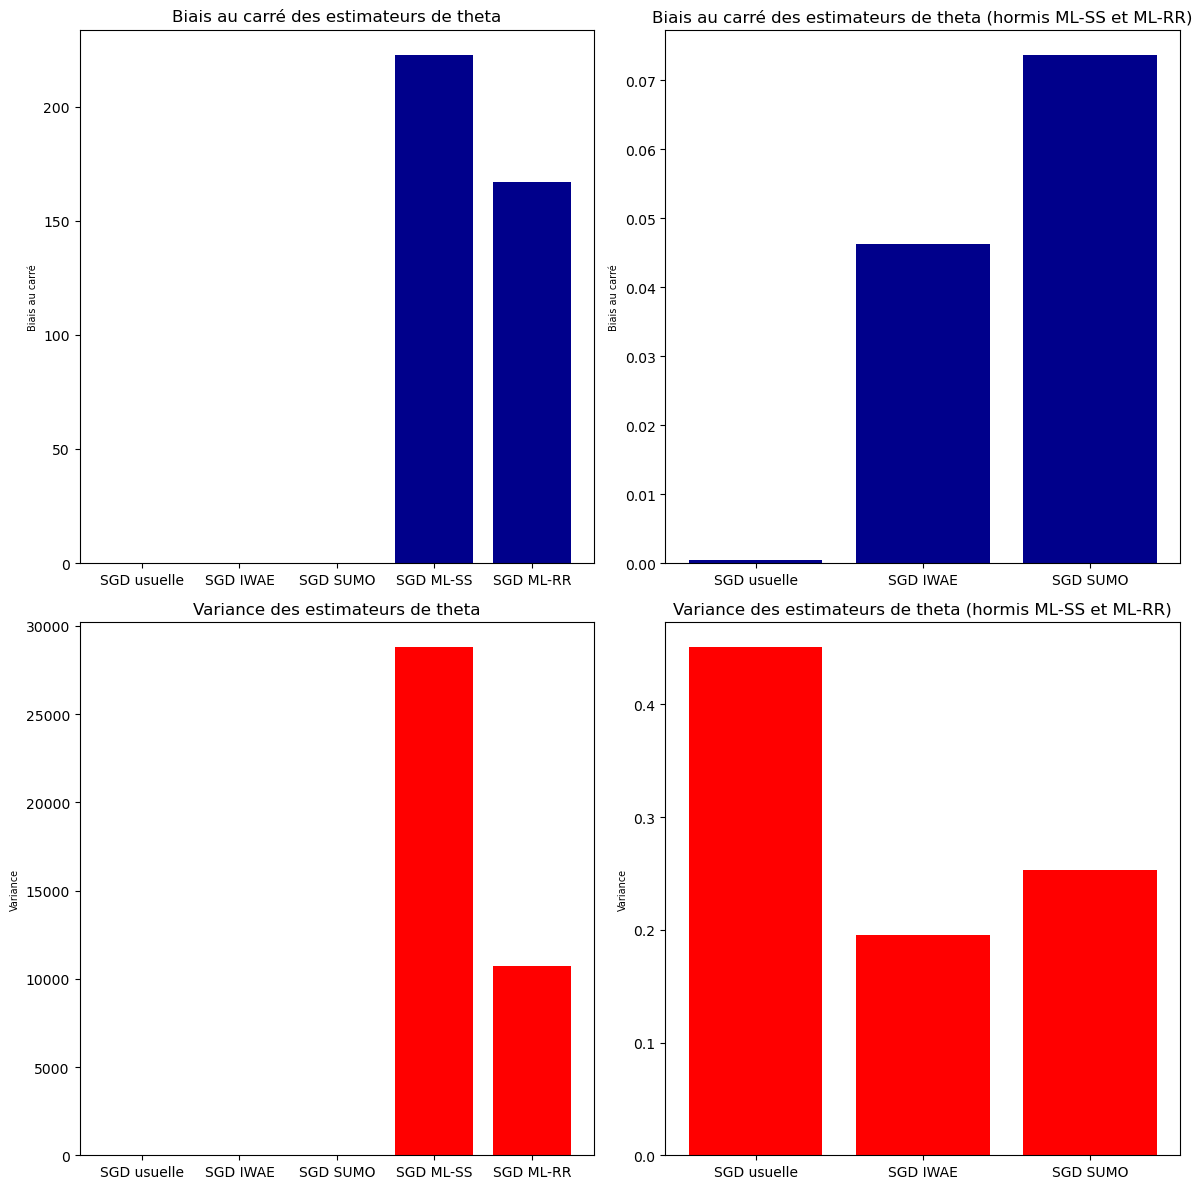

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

estimateur=["SGD usuelle","SGD IWAE","SGD SUMO","SGD ML-SS","SGD ML-RR"]
liste_biais_carre=[norm_biais_SGD_M**2, norm_biais_IWAE_M**2, norm_biais_SUMO_M**2, norm_biais_SS_M**2, norm_biais_RR_M**2]
liste_variances=[var_SGD_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M]

axs[0,0].bar(estimateur,liste_biais_carre, color="darkblue")
axs[0,0].set_title("Biais au carré des estimateurs de theta")
axs[0,0].set_ylabel("Biais au carré", size=7)

axs[1,0].bar(estimateur, liste_variances, color="red")
axs[1,0].set_title("Variance des estimateurs de theta")
axs[1,0].set_ylabel("Variance", size=7)

axs[0,1].bar(estimateur[0:3],liste_biais_carre[0:3], color="darkblue")
axs[0,1].set_title("Biais au carré des estimateurs de theta (hormis ML-SS et ML-RR)")
axs[0,1].set_ylabel("Biais au carré", size=7)

axs[1,1].bar(estimateur[0:3], liste_variances[0:3], color="red")
axs[1,1].set_title("Variance des estimateurs de theta (hormis ML-SS et ML-RR)")
axs[1,1].set_ylabel("Variance", size=7)
fig.tight_layout()
plt.savefig("variance_biais_theta_sgd.png")
plt.show()

In [2]:
# %store norm_biais_SGD_M
# %store norm_biais_IWAE_M
# %store norm_biais_SUMO_M
# %store norm_biais_SS_M
# %store norm_biais_RR_M

# %store var_SGD_M
# %store var_IWAE_M
# %store var_SUMO_M
# %store var_SS_M
# %store var_RR_M